In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Auticate access to Google Drive
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir = '/content/drive/My Drive/chest_xray'

train_dir = os.path.join(base_dir, 'train')
validation_dir =os.path.join(base_dir, 'val')

In [4]:
train_dir

'/content/drive/My Drive/chest_xray/train'

In [18]:
validation_dir

'/content/drive/My Drive/chest_xray/val'

In [19]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()


#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2019-08-08 16:37:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   156MB/s    in 0.5s    

2019-08-08 16:37:48 (156 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                               

In [20]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [22]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
train_stop_dir =os.path.join(train_dir, 'NORMAL')  
train_random_dir =os.path.join(train_dir, 'PNEUMONIA')  
validation_stop_dir =os.path.join(validation_dir, 'NORMAL')
validation_random_dir = os.path.join(validation_dir, 'PNEUMONIA')

In [0]:
num_stop_tr = len(os.listdir(train_stop_dir))
num_random_tr = len(os.listdir(train_random_dir))

num_stop_val = len(os.listdir(validation_stop_dir))
num_random_val = len(os.listdir(validation_random_dir))

total_train = num_stop_tr + num_random_tr
total_val = num_stop_val + num_random_val

In [25]:
print('total training Normal images:', num_stop_tr)
print('total training  PNEUMONIA images:', num_random_tr)

print('total validation Normal images:', num_stop_val)
print('total validation PNEUMONIA images:', num_random_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Normal images: 1342
total training  PNEUMONIA images: 3876
total validation Normal images: 9
total validation PNEUMONIA images: 9
--
Total training images: 5218
Total validation images: 18


In [26]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 50,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 4,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [27]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 10,
            validation_steps = 25,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/10
10/10 - 169s - loss: 0.6413 - acc: 0.7780 - val_loss: 0.6069 - val_acc: 0.6400
Epoch 2/10
10/10 - 158s - loss: 0.2975 - acc: 0.8780 - val_loss: 1.1221 - val_acc: 0.5700
Epoch 3/10
10/10 - 165s - loss: 0.3055 - acc: 0.8580 - val_loss: 0.8283 - val_acc: 0.5600
Epoch 4/10
10/10 - 170s - loss: 0.2759 - acc: 0.8860 - val_loss: 3.5584 - val_acc: 0.5000
Epoch 5/10
10/10 - 165s - loss: 0.2901 - acc: 0.8880 - val_loss: 3.8344 - val_acc: 0.5000
Epoch 6/10
10/10 - 166s - loss: 0.2715 - acc: 0.9040 - val_loss: 2.1168 - val_acc: 0.5000
Epoch 7/10
10/10 - 159s - loss: 0.1799 - acc: 0.9300 - val_loss: 2.6974 - val_acc: 0.5000
Epoch 8/10
10/10 - 154s - loss: 0.2071 - acc: 0.9270 - val_loss: 4.5600 - val_acc: 0.4900
Epoch 9/10
10/10 - 163s - loss: 0.2100 - acc: 0.9240 - val_loss: 2.1159 - val_acc: 0.5000
Epoch 10/10
10/10 - 173s - loss: 0.2113 - acc: 0.9120 - val_loss: 4.2943 - val_acc: 0.4900


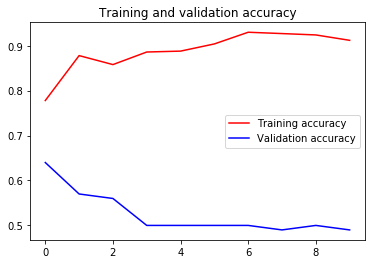

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [30]:
test_generator = test_datagen.flow_from_directory(
    directory= '/content/drive/My Drive/chest_xray/test',
        target_size=(150, 150),
        shuffle = False,
        batch_size=1
)


Found 624 images belonging to 2 classes.


In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [0]:
predict = model.predict_generator(test_generator,steps = nb_samples)


In [33]:
print(predict)


[[0.9987587 ]
 [0.99731195]
 [0.9998779 ]
 [0.9847231 ]
 [0.9999182 ]
 [0.9954613 ]
 [0.9990687 ]
 [0.99985063]
 [0.9999192 ]
 [0.8334317 ]
 [0.9999542 ]
 [0.99950576]
 [0.99996567]
 [0.99831283]
 [0.9996911 ]
 [0.99944705]
 [0.999985  ]
 [0.99886215]
 [0.9995654 ]
 [0.99877983]
 [0.9999558 ]
 [0.9999945 ]
 [0.9916481 ]
 [0.9999517 ]
 [0.99991727]
 [0.9990029 ]
 [0.9999449 ]
 [0.9987465 ]
 [0.9999932 ]
 [0.99979955]
 [0.99997544]
 [0.9995691 ]
 [0.9998776 ]
 [0.99993515]
 [0.99987674]
 [0.9999349 ]
 [0.98095196]
 [0.9929771 ]
 [0.98757845]
 [0.9082861 ]
 [0.9956143 ]
 [0.98045635]
 [0.91490865]
 [0.16907667]
 [0.99998915]
 [0.99995565]
 [0.9999037 ]
 [0.99957305]
 [0.99966323]
 [0.8810817 ]
 [0.9822449 ]
 [0.9988675 ]
 [0.9725715 ]
 [0.9997645 ]
 [0.9884723 ]
 [0.9996487 ]
 [0.9966145 ]
 [0.9993013 ]
 [0.998877  ]
 [0.99937314]
 [0.98660034]
 [0.9997712 ]
 [0.9999466 ]
 [0.8288964 ]
 [0.9990783 ]
 [0.97208226]
 [0.9999336 ]
 [0.99999034]
 [0.99721813]
 [0.99998605]
 [0.9958417 ]
 [0.99